In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd 
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[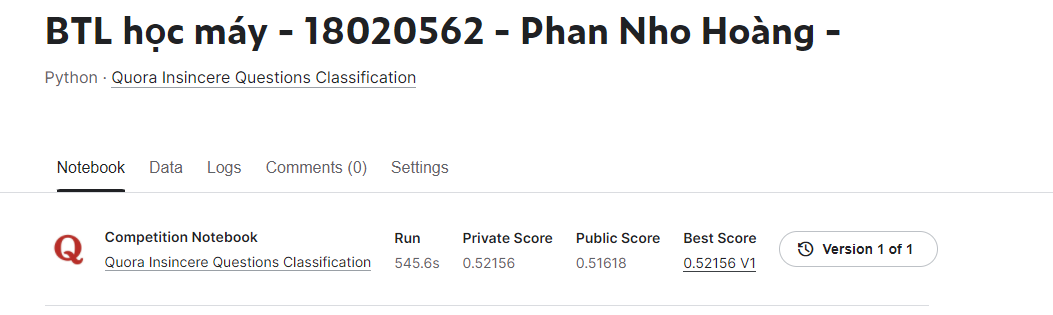](http://)

# Kết quả chạy trên kaggle:

# Mô tả bài toán
> ***Yêu cầu đặt ra là với các câu hỏi trên Quora có phải là câu hỏi toxic hay không?***
* Input: Các câu dưới dạng text.
* Output: 1(Là câu hỏi toxic) or 0(Là câu bình thường) ?


# Tiến hành bài toán theo:
**1. Xử lý dữ liệu**
> Vì đầu vào là text nên chúng ta cần xử lý trước khi train

**2. Training dữ liệu với mô hình Logistic Regression**

**3. Đánh giá và kết luận**

# 1. Xử lý dữ liệu

**Đọc dữ liệu đầu vào gồm 3 tập: **

* Sample submission
* Train
* Test


In [ ]:
df_sample_sub = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/sample_submission.csv')
df_train = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/train.csv')
df_test = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/test.csv')

**Dữ liệu sẽ hiển thị dạng**

In [ ]:
# Lấy dữ liệu tập sample_sub
df_sample_sub.head()

In [ ]:
# Lấy dữ liệu tập train
df_train.head()

**Dữ liệu vào gồm các question_text là dạng text. -> Ta sẽ phải xử lý dấu câu, các "stopword", từ đồng nghĩa để có thể dễ dàng hơn cho việc train.**

In [ ]:
# Thông tin tập train
df_train.info()

In [ ]:
# Lượng dữ liệu 
df_train.target.value_counts()

**Đối với tập dữ liệu Train**

**Có 1225312 câu hỏi bình thường và 80810 câu hỏi Toxic**

**-> Tỉ lệ chênh lệch lớn và các câu hỏi toxic vẫn xuất hiện khá nhiều chiếm tới 80810 câu trong tập dữ liệu.**


**Sử dụng Natural Language Toolkit để xử lý ngôn ngữ tự nhiên, nhanh chóng và có tác dụng làm sạch dữ liệu, xử lý dữ liệu đầu vào cho các thuật toán Machine Learning và giúp ta xử lý các stopwords - là các từ có tần số xuất hiện nhiều nhưng mang lại giá trị ý nghĩa không khác mấy so với khi ta bỏ đi.
Ví dụ: my, me, ...**

In [ ]:
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()

def lemSentence(sentence):
    token_words = word_tokenize(sentence)
    lem_sentence = []
    for word in token_words:
        lem_sentence.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        lem_sentence.append(" ")
    return "".join(lem_sentence)

**Tiến hành clean dữ liệu**

In [ ]:
def clean(message, lem = True):
    # Loại bỏ dấu câu (ví dụ: các dấu !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~)
    message = message.translate(str.maketrans('', '', string.punctuation))
    
    # Loại bỏ số
    message = message.translate(str.maketrans('', '', string.digits))
    
    # Loại bỏ "stopwords"
    message = [word for word in word_tokenize(message) if not word.lower() in nltk_stopwords]
    message = ' '.join(message)
    
    if lem:
        message = lemSentence(message)
    
    return message

In [ ]:
# Clean các câu hỏi trong tập train
df_train['question_text_cleaned'] = df_train.question_text.apply(lambda x: clean(x, True))

**Bảng 20 dữ liệu sau khi tiến hành làm sạch sẽ hiển thị như sau:**

In [ ]:
df_train.head(10)

# 2. Training dữ liệu với mô hình hồi quy logistic (Logistic Regression)

**> Tổng quan về bài toán được trình bày trên link notion đã có ở trên lớp: https://tricky-tax-444.notion.site/5acbc01b2a924fe6818d046339a68d23?v=6bc56f801d7c4ce1a1eefd4b60ef57cf&p=cf099245442c461aa36305456a17183e
và https://machinelearningcoban.com/2017/01/27/logisticregression/**

**Tuy nhiên sau khi đó ta vẫn phải mã hoá văn bản. Đầu vào cần được mã hóa dưới dạng số nguyên hoặc giá trị dấu phẩy động, để sử dụng làm đầu vào trong thuật toán học máy. Quá trình này được gọi là vecto hoá.**

**-> Ta sẽ sử dụng CountVectorizer để chuyển dữ liệu đầu vào từ định dạng Text thành Vectơ**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
model = LogisticRegression(C=1, random_state=0)

vectorize_model_pipeline = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('model', model)
])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train['question_text_cleaned'], df_train['target'], test_size = 0.3)
vectorize_model_pipeline.fit(X_train, y_train)

In [ ]:
predictions = vectorize_model_pipeline.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

**Tương tự ta sẽ tiến hành với tập test**

In [ ]:
# Clean trong tập test
df_test['question_text_cleaned'] = df_test.question_text.apply(lambda x: clean(x, True))

In [ ]:
df_test['prediction'] = vectorize_model_pipeline.predict(df_test['question_text_cleaned'])

In [ ]:
df_final = df_test[['qid','prediction']]
df_final.set_index('qid', inplace = True)

In [ ]:
df_final.head(10)

In [ ]:
# Ghi lại kết quả
df_final.to_csv('submission.csv')

# 3. Đánh giá, kết luận
**Kết quả khi thực hiện mô hình Logistic Regression:**

Run: **545.6s**

Private Score: **0.52156**

Public Score: **0.51618**

Best Score: **0.52156 V1**
